In [17]:
import pandas as pd

# Loads the merged dataset with customer data
ords_prods_merged_final = pd.read_pickle('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Prepared Data/ords_prods_merged_final.pkl')
customers = pd.read_csv('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/customers.csv')

# Quick check
ords_prods_merged_final.head()


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,price_label,busiest_day,day_type,busiest_period_of_day,gender,state,age,num_dependents,marital_status,income
0,2539329,1,prior,1,2,8,0.0,196,1,0,...,Mid-range product,Least busy day,Average days,Average orders,Female,Alabama,31,3,married,40423
1,2539329,1,prior,1,2,8,0.0,14084,2,0,...,Mid-range product,Least busy day,Average days,Average orders,Female,Alabama,31,3,married,40423
2,2539329,1,prior,1,2,8,0.0,12427,3,0,...,Low-range product,Least busy day,Average days,Average orders,Female,Alabama,31,3,married,40423
3,2539329,1,prior,1,2,8,0.0,26088,4,0,...,Low-range product,Least busy day,Average days,Average orders,Female,Alabama,31,3,married,40423
4,2539329,1,prior,1,2,8,0.0,26405,5,0,...,Low-range product,Least busy day,Average days,Average orders,Female,Alabama,31,3,married,40423


## Question 2
## Data Privacy Consideration

The dataset contained personally identifiable information (PII) in the form of customer first and last names previously. 
Since these are not required for analysis, they were removed to ensure data privacy and comply with ethical handling of sensitive information.



In [3]:
## Question 3

# 1. Defines region mapping using FULL state names
region_map = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont',
                  'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Indiana', 'Illinois', 'Michigan', 'Ohio', 'Wisconsin', 'Iowa', 'Kansas',
                'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
    'South': ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia',
              'District of Columbia', 'West Virginia', 'Alabama', 'Kentucky', 'Mississippi', 'Tennessee',
              'Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
    'West': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming',
             'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']
}

# 2. Creates reverse mapping: state -> region
state_to_region = {state: region for region, states in region_map.items() for state in states}

# 3. Maps state column to region column
ords_prods_merged_final['region'] = ords_prods_merged_final['state'].map(state_to_region)

# 4. Checks if it worked
print(ords_prods_merged_final['region'].value_counts(dropna=False))


region
South        10801982
West          8300617
Midwest       7604016
Northeast     5728444
Name: count, dtype: int64


In [5]:
# Creates avg price per user
ords_prods_merged_final['avg_price_per_user'] = ords_prods_merged_final.groupby('user_id')['prices'].transform('mean')

# Creates spending flag column
ords_prods_merged_final.loc[ords_prods_merged_final['avg_price_per_user'] < 10, 'spending_flag'] = 'Low spender'
ords_prods_merged_final.loc[ords_prods_merged_final['avg_price_per_user'] >= 10, 'spending_flag'] = 'High spender'


# 5. Crosstab to compare % of high vs low spenders by region
spending_by_region = pd.crosstab(
    ords_prods_merged_final['region'],
    ords_prods_merged_final['spending_flag'],
    normalize='index'
) * 100

print(spending_by_region)


spending_flag  High spender  Low spender
region                                  
Midwest            2.053454    97.946546
Northeast          1.891404    98.108596
South              1.946217    98.053783
West               1.937410    98.062590


In [6]:
## Question 4
# Counts number of orders per user
ords_prods_merged_final['order_count'] = ords_prods_merged_final.groupby('user_id')['order_number'].transform('max')

ords_prods_merged_final['exclusion_flag'] = 'Active'

ords_prods_merged_final.loc[ords_prods_merged_final['order_count'] < 5, 'exclusion_flag'] = 'Low activity'

# Keeps only active customers
ords_prods_active = ords_prods_merged_final[ords_prods_merged_final['exclusion_flag'] == 'Active']

ords_prods_merged_final['exclusion_flag'].value_counts()


exclusion_flag
Active          30993489
Low activity     1441570
Name: count, dtype: int64

In [7]:
ords_prods_active.to_pickle('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Prepared Data/ords_prods_active.pkl')


In [14]:
## Question 5
import numpy as np
import pandas as pd


# Assign safely using .loc[row_indexer, column_name]
ords_prods_active.loc[:, 'baby_flag'] = (
    (ords_prods_active['department_id'] == 18).astype(int)
)

## Helper flags
ords_prods_active.loc[:, 'baby_flag'] = (
    ords_prods_active.groupby('user_id')['baby_flag'].transform('max')
)

ords_prods_active.loc[:, 'daytime_flag'] = np.where(
    ords_prods_active['order_hour_of_day'].between(6, 17), 'Day', 'Night'
)

# user-level figures
ords_prods_active.loc[:, 'avg_income'] = ords_prods_active['income']
ords_prods_active.loc[:, 'avg_age'] = ords_prods_active['age']
ords_prods_active.loc[:, 'num_dependents'] = ords_prods_active['num_dependents']



# Rule sets
conditions = [
    #0 Young adult shoppers (no kids, ≤35, mid-or-low income)
    (
        (ords_prods_active['avg_age']      <= 35) &
        (ords_prods_active['num_dependents'] == 0)
    ),
    #1 Young parents (≤40, ≥1 dependent, buys baby products)
    (
        (ords_prods_active['avg_age']       <= 40) &
        (ords_prods_active['num_dependents'] >= 1) &
        (ords_prods_active['baby_flag']      == 1)
    ),
    #2 High-income professionals (age 30-55, income ≥120 k$, ≤1 dependent)
    (
        (ords_prods_active['avg_income']    >= 120000) &
        (ords_prods_active['avg_age'].between(30, 55)) &
        (ords_prods_active['num_dependents'] <= 1)
    ),
    #3 Large-family shoppers (≥2 dependents, any age)
    (
        (ords_prods_active['num_dependents'] >= 2)
    ),
    #4 Seniors (age ≥60)
    (
        (ords_prods_active['avg_age']       >= 60)
    )
]

choices = [
    'Single adult',
    'Young parent',
    'High-income professional',
    'Family bulk shopper',
    'Senior'
]

ords_prods_active.loc[:, 'customer_profile'] = np.select(conditions, choices, default='General')


ords_prods_active['customer_profile'].value_counts()


customer_profile
Family bulk shopper         13755404
General                      5480949
Senior                       5233325
Young parent                 2647755
Single adult                 2179775
High-income professional     1696281
Name: count, dtype: int64

In [15]:
ords_prods_active.to_pickle(
    '/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Prepared Data/ords_prods_active_profiled.pkl'
)


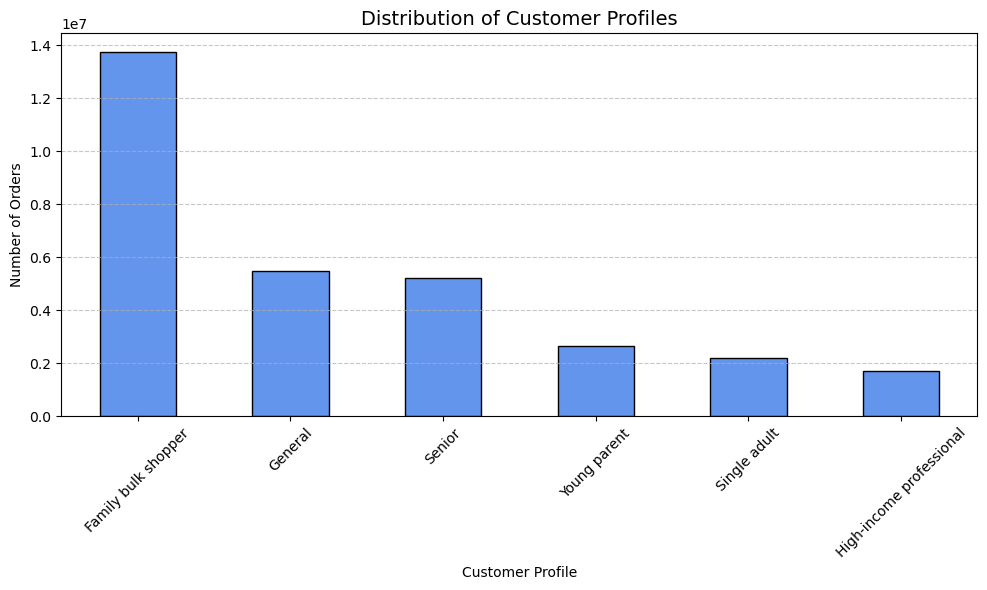

In [16]:
## Question 6
profile_counts = ords_prods_active['customer_profile'].value_counts().sort_values(ascending=False)

import matplotlib.pyplot as plt

# Bar chart
plt.figure(figsize=(10, 6))
profile_counts.plot(kind='bar', color='cornflowerblue', edgecolor='black')

plt.title('Distribution of Customer Profiles', fontsize=14)
plt.xlabel('Customer Profile')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Customer Profile Distribution – Bar Chart

This bar chart shows how Instacart customers are distributed across different profile types (e.g., *Young parent*, *Senior*, *Family bulk shopper*).

**Why this chart matters:**
- Highlights which customer types place the most orders.
- Helps identify key segments for personalized marketing.
- Supports strategic decisions for loyalty programs and product targeting.

The "General" group includes users who didn’t meet specific profile criteria.


In [22]:
## Question 7
profile_summary = ords_prods_active.groupby('customer_profile').agg({
    'order_number': ['min', 'mean', 'max'],
    'prices': ['min', 'mean', 'max']
})

# Flatten multi-level column names
profile_summary.columns = ['_'.join(col).strip() for col in profile_summary.columns.values]
profile_summary.reset_index(inplace=True)

profile_summary.head()

,customer_profile,order_number_min,order_number_mean,order_number_max,prices_min,prices_mean,prices_max
0,Family bulk shopper,1,17.288404,99,1.0,12.222278,99999.0
1,General,1,17.402279,99,1.0,10.712467,99999.0
2,High-income professional,1,17.822170,99,1.0,17.525949,99999.0
3,Senior,1,17.721275,99,1.0,11.402476,99999.0
4,Single adult,1,17.735227,99,1.0,12.256509,99999.0


In [28]:
## Question 8
profile_region = ords_prods_active.groupby(['region', 'customer_profile'])['user_id'].count().reset_index()
profile_region = profile_region.pivot(index='region', columns='customer_profile', values='user_id')
profile_region.fillna(0, inplace=True)
profile_region.head()


customer_profile,Family bulk shopper,General,High-income professional,Senior,Single adult,Young parent
region,,,,,,
Midwest,3208119,1321732,421517,1222738,492062,601734
Northeast,2416030,937943,285048,948754,397774,484615
South,4592864,1798156,548976,1733007,744691,903137
West,3538391,1423118,440740,1328826,545248,658269


In [29]:
profile_department = ords_prods_active.groupby(['department_id', 'customer_profile'])['product_id'].count().reset_index()
profile_department = profile_department.pivot(index='department_id', columns='customer_profile', values='product_id')
profile_department.fillna(0, inplace=True)
profile_department.head()


customer_profile,Family bulk shopper,General,High-income professional,Senior,Single adult,Young parent
department_id,,,,,,
1.0,943184,370168,118103,359999,146506,185382
2.0,14960,6173,1796,5905,2541,3036
3.0,496361,196399,63257,190948,80332,97729
4.0,4042838,1614974,500878,1534324,638358,747904
5.0,68355,27247,9585,24056,10243,5141


### Regional & Departmental Patterns by Customer Profile

- **Regional differences**: Certain profiles, like "Young parent" or "Senior," appear more frequently in specific regions.
- **Department preference**: Some customer types (e.g., "Family bulk shopper") frequently purchase from departments like beverages, dairy, or snacks.
- These patterns can help tailor **regional marketing campaigns** and product placement by customer profile.


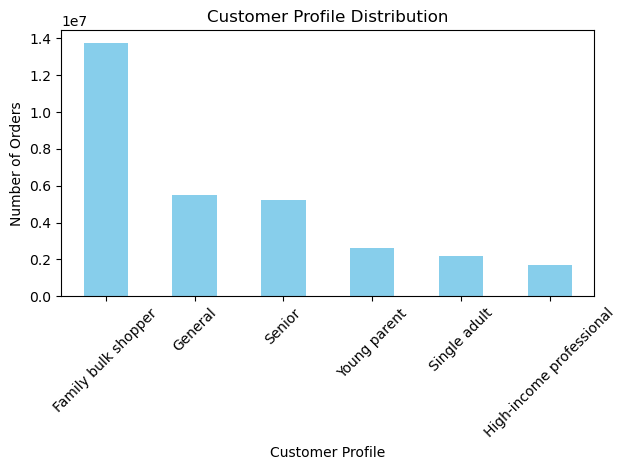

In [31]:
## Question 9
ords_prods_active['customer_profile'].value_counts().plot.bar(
    color='skyblue',
    title='Customer Profile Distribution'
)
plt.xlabel('Customer Profile')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Visualizations/customer_profile_distribution.png')
plt.show()


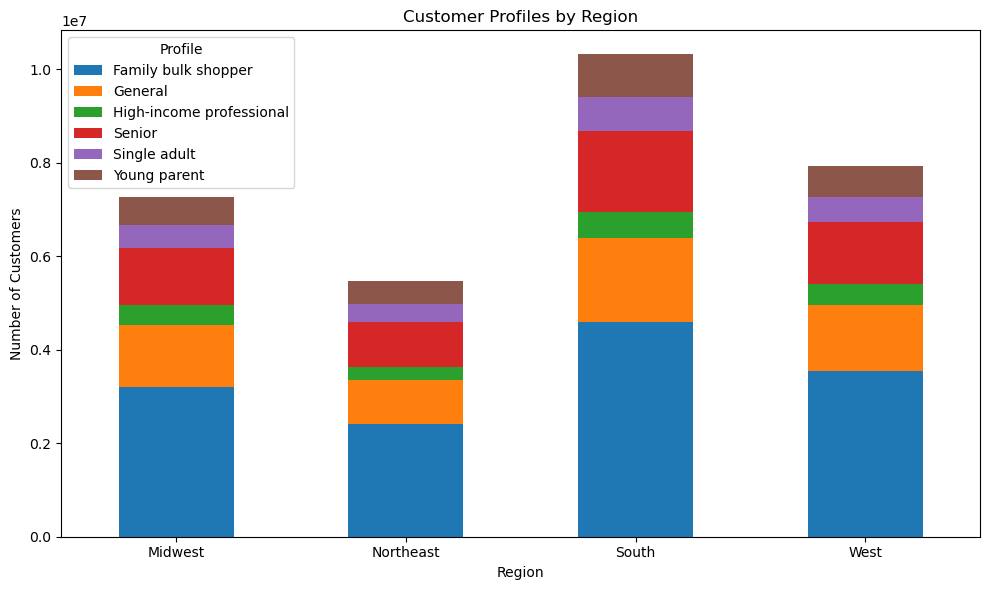

In [32]:
profile_region.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    title='Customer Profiles by Region'
)
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.legend(title='Profile')
plt.tight_layout()
plt.savefig('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Visualizations/profiles_by_region.png')
plt.show()


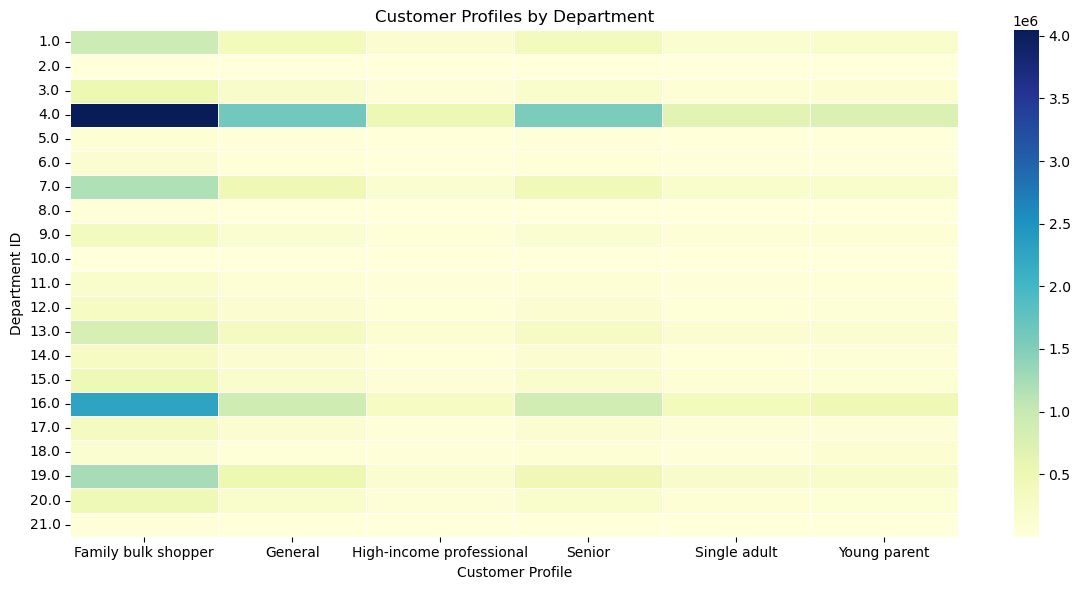

In [34]:
profile_dept = ords_prods_active.groupby(['department_id', 'customer_profile'])['product_id'] \
    .count().reset_index()

profile_dept = profile_dept.pivot(index='department_id', columns='customer_profile', values='product_id')
profile_dept.fillna(0, inplace=True)


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(profile_dept, cmap='YlGnBu', linewidths=0.5)
plt.title('Customer Profiles by Department')
plt.xlabel('Customer Profile')
plt.ylabel('Department ID')
plt.tight_layout()
plt.savefig('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Visualizations/profiles_by_department.png')
plt.show()



In [35]:
ords_prods_active.to_pickle('/Users/cem/Desktop/Data Immersion/Achievement 4_Project/Data/Prepared Data/final_dataset_part1.pkl')
